In [1]:
import pandas as pd
import numpy as np
import feed as f
from dapc import defs
import v20
import matplotlib.pyplot as plt

from datetime import datetime
print(datetime.now())

2022-03-09 09:16:51.903014


In [2]:
# create context
ctx = v20.Context(hostname= 'api-fxpractice.oanda.com', token=defs.key)
ctx.set_header(key='Authorization', value=defs.key)
# streaming contenxt
ctxs=v20.Context(hostname='stream-fxpractice.oanda.com', token=defs.key)
ctxs.set_header(key='Authorization', value=defs.key)

In [3]:
def get_candles(inst, count=15, timeframe='M5'):
    params=dict(price='MBA', granularity=timeframe, count=count)
    candles = ctx.instrument.candles(inst, **params).get('candles')
    prices=['mid', 'bid', 'ask']
    ohlc=['ohlc']
    s=[]
    for c in candles:
        c=c.dict()
        row={}
        row['complete'] = c['complete']
        row['volume'] = c['volume']
        for p in prices:
            for oh in 'ohlc':
                row[f'{p}_{oh}']=float(c[p][oh])
        s.append(row)
    df= pd.DataFrame.from_dict(s)
    return df

In [14]:
def process_data(df, window=10, deg=1):
    df['spread']    = df['ask_c']-df['bid_c']
    # HH-LL
    df['lows']      = np.sign(df.mid_l-df.mid_l.shift(1))
    df['highs']     = np.sign(df.mid_h-df.mid_h.shift(1))
    df['hilo']      = np.sign(df.lows+df.highs)
    # MoM
    df['mom']       = df.mid_c.diff(window)
    df['mom_pos']   = np.sign(df.mom)
    df['mom_slope'] = np.sign(df.mom.diff(1))
    # RoC
    df['roc']       = df.mid_c / df.mid_c.shift(window)
    df['roc_pos']   = np.sign(df.roc)
    df['roc_slope'] = np.sign(df.roc.diff(1))
    # SMA
    df['sma1']      = df.mid_c.rolling(window).mean()
    # stochastic
    hi    = df['mid_h'].rolling(window).max()
    lo    = df['mid_l'].rolling(window).min()
    df['STO_K']        = (df['mid_c'] - lo)*100/(hi - lo)
    df['STO_D']        = df['STO_K'].rolling(3).mean()
    # linear regression
    x = np.arange(len(df))
    y = list(df.mid_c.values)
    z = np.polyfit(x, y ,deg)
    df['linreg']    = np.polyval(z, x)
    df['linreg_up'] = df.linreg + df.mid_c.std()
    df['linreg_lp'] = df.linreg - df.mid_c.std()
    df['linreg_s'] = np.sign(df.linreg - df.linreg.shift(1))
    # Mom ret
    con1 = (df.mom<0) & (df.mom_slope>0) & (df.mom_slope.shift(1)>0) & (df.mom_slope.shift(2)<0) & (df.mom_slope.shift(3)<0) & (df.mom_slope.shift(4)<0)
    con2 = (df.mom>0) & (df.mom_slope<0) & (df.mom_slope.shift(1)<0) & (df.mom_slope.shift(2)>0) & (df.mom_slope.shift(3)>0) & (df.mom_slope.shift(4)<0)
    df['mom_ret']   = np.where(con1, 1, 0)
    df['mom_ret']   = np.where(con2, -1, df['mom_ret'] )
    # signal
    df['signal']    = np.where((df.hilo+df.mom_pos+df.mom_slope==3),1,0)
    df['signal']    = np.where((df.hilo+df.mom_pos+df.mom_slope==-3),-1,df['signal'])
    # stochastic signal
    df['signal_stoch']    = np.where((df.STO_K > 85),-1,0)
    df['signal_stoch']    = np.where((df.STO_K < 15), 1,0)
    # avg line
    df['avgline'] = (df.ask_h + df.bid_l)/2
    df['avgline_slope'] = np.sign(df.avgline-df.avgline.shift(1))
    df['returns'] = np.log(df.mid_c/df.mid_c.shift(1))
    # feedback
    print('signal:', df['signal'].values[-1])
    return df

In [15]:
def plot_data(df):
    ax1 = plt.subplot2grid(shape=(4, 1), loc=(0, 0), rowspan=2) 
    df.mid_c.plot(drawstyle='steps-post',style='r-')
    
    df.linreg.plot()
    df.linreg_up.plot()
    df.linreg_lp.plot()

    ax2 = plt.subplot2grid((4, 1), (2, 0), rowspan=1) 
    ax2.bar(df.index, df.mom, color='r');

    ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1) 
    ax3.bar(df.index, df.volume);
    plt.tight_layout()    

In [16]:
def plot_subplots(df, w=8 , h=8):
    cols=['mid_c','STO_K', 'mom','mom_ret', 'roc']
    axs=df[cols].plot(drawstyle='steps-post', grid=False,subplots=True,figsize=(w,h))
    df.sma1.plot(ax=axs[0])

    axs[1].axhline(y=20)
    axs[1].axhline(y=80)

    mom_qu= df.mom.quantile(.9).round(4)
    mom_ql= df.mom.quantile(.1).round(4)
    print(mom_ql, mom_qu)

    axs[2].axhline(y=0, ls='-', lw=.5, c='k')
    axs[2].axhline(y=mom_ql, ls='--', lw=.5, c='r')
    axs[2].axhline(y=mom_qu, ls='--', lw=.5, c='r')

    spikes=list(df[(df.mom > mom_qu) | (df.mom < mom_ql)].index)

    for x in axs:
        for s in spikes:
            x.axvline(x=s, lw=1, ls='--')
    plt.tight_layout()

In [17]:
df0 = get_candles('EUR_USD', count=100, timeframe='M5')
df = df0.copy()

In [18]:
df0.bid_l.head(10).min()

1.08959

In [19]:
df= process_data(df, deg=1)
df.iloc[:,-20:].tail(20)

signal: 0


,hilo,mom,mom_pos,mom_slope,roc,roc_pos,roc_slope,sma1,STO_K,STO_D,linreg,linreg_up,linreg_lp,linreg_s,mom_ret,signal,signal_stoch,avgline,avgline_slope,returns
80,-1.0,-0.00038,-1.0,-1.0,0.999652,1.0,-1.0,1.092116,19.708029,38.199513,1.092007,1.092669,1.091345,1.0,0,-1,0,1.091860,-1.0,-0.000073
81,-1.0,-0.00010,-1.0,1.0,0.999908,1.0,1.0,1.092106,5.797101,17.017525,1.092022,1.092684,1.091360,1.0,0,0,1,1.091615,-1.0,-0.000183
82,1.0,0.00003,1.0,1.0,1.000027,1.0,1.0,1.092109,23.188406,16.231179,1.092037,1.092699,1.091375,1.0,0,1,0,1.091625,1.0,0.000220
83,0.0,-0.00038,-1.0,-1.0,0.999652,1.0,-1.0,1.092071,24.285714,17.757074,1.092052,1.092714,1.091390,1.0,0,0,0,1.091610,-1.0,0.000000
84,-1.0,-0.00090,-1.0,-1.0,0.999176,1.0,-1.0,1.091981,26.203209,24.559110,1.092067,1.092728,1.091405,1.0,0,-1,0,1.091340,-1.0,-0.000293
85,1.0,-0.00104,-1.0,-1.0,0.999048,1.0,-1.0,1.091877,35.135135,28.541353,1.092082,1.092743,1.091420,1.0,0,0,0,1.091560,1.0,0.000147
86,1.0,-0.00076,-1.0,1.0,0.999304,1.0,1.0,1.091801,43.352601,34.896982,1.092097,1.092758,1.091435,1.0,0,0,0,1.091595,1.0,0.000092
87,0.0,-0.00041,-1.0,1.0,0.999625,1.0,1.0,1.091760,70.552147,49.679961,1.092112,1.092773,1.091450,1.0,1,0,0,1.091800,1.0,0.000366
88,0.0,-0.00048,-1.0,-1.0,0.999561,1.0,-1.0,1.091712,65.100671,59.668473,1.092127,1.092788,1.091465,1.0,0,0,0,1.091905,1.0,-0.000165
89,1.0,0.00058,1.0,1.0,1.000531,1.0,1.0,1.091770,87.730061,74.460960,1.092142,1.092803,1.091480,1.0,0,1,0,1.092205,1.0,0.000421


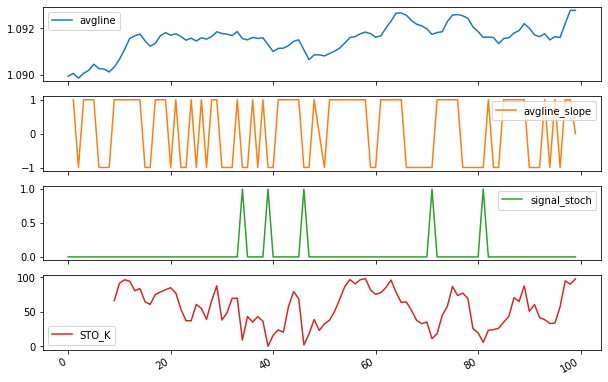

In [20]:
cols=['avgline', 'avgline_slope', 'signal_stoch', 'STO_K']
df[cols].plot(subplots=True, figsize=(10,7));

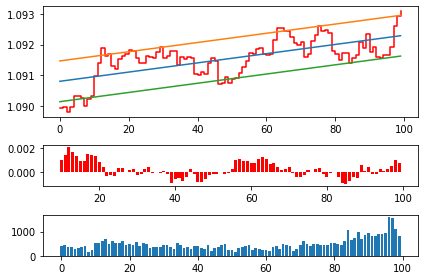

In [21]:
plot_data(df)

-0.0005 0.0011


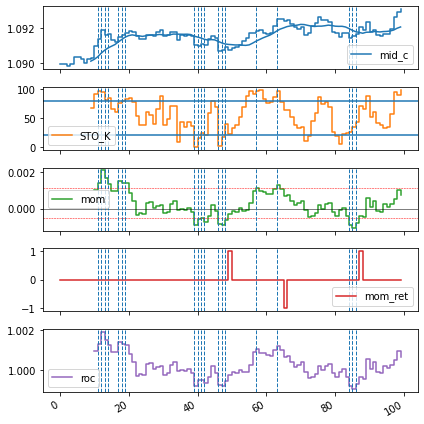

In [22]:
plot_subplots(df,6,6)

signal: 0


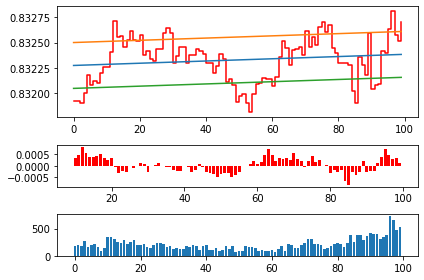

signal: 0


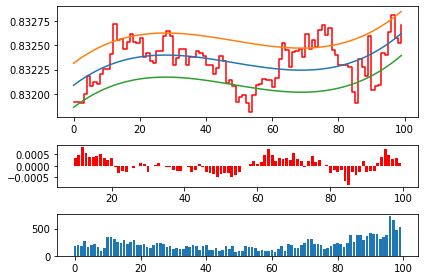

In [27]:
df0 = get_candles('EUR_GBP', count=100, timeframe='M5')
df= process_data(df0, deg=1)
plot_data(df)
plt.show()
df= process_data(df0, deg=3)
plot_data(df)
# plot_subplots(df0)

signal: 0
-0.0005 0.0007


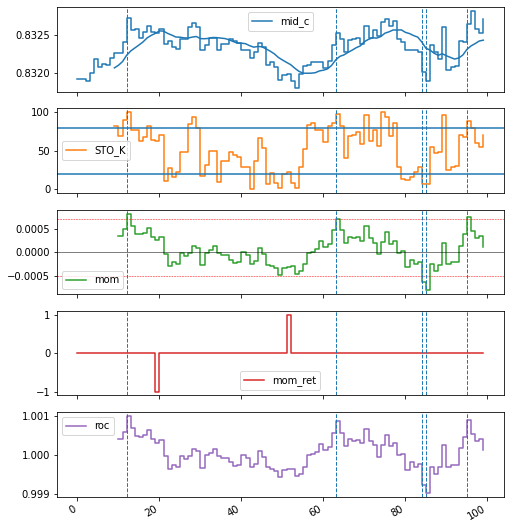

In [38]:
df= process_data(df0.copy())
cols=['mid_c','STO_K', 'mom','mom_ret', 'roc']
axs=df[cols].plot(drawstyle='steps-post', grid=False,subplots=True,figsize=(8,10))
df.sma1.plot(ax=axs[0])

axs[1].axhline(y=20)
axs[1].axhline(y=80)

mom_qu= df.mom.quantile(.98).round(4)
mom_ql= df.mom.quantile(.02).round(4)
print(mom_ql, mom_qu)

axs[2].axhline(y=0, ls='-', lw=.5, c='k')
axs[2].axhline(y=mom_ql, ls='--', lw=.5, c='r')
axs[2].axhline(y=mom_qu, ls='--', lw=.5, c='r')

spikes=list(df[(df.mom > mom_qu) | (df.mom < mom_ql)].index)

for x in axs:
    for s in spikes:
        x.axvline(x=s, lw=1, ls='--')

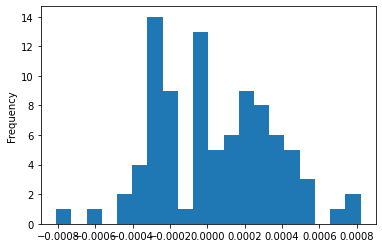

In [29]:
df.mom.plot.hist(bins=20);

In [30]:
df.columns

Index(['complete', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o',
       'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'spread',
       'lows', 'highs', 'hilo', 'mom', 'mom_pos', 'mom_slope', 'roc',
       'roc_pos', 'roc_slope', 'sma1', 'STO_K', 'STO_D', 'linreg', 'linreg_up',
       'linreg_lp', 'linreg_s', 'mom_ret', 'signal', 'signal_stoch', 'avgline',
       'avgline_slope', 'returns'],
      dtype='object')

In [31]:
cols=['volume', 'mid_l','lows','mid_c', 'ask_c', 'bid_c','spread', 'mid_h','highs', 'hilo', 'mom', 'mom_pos', 'mom_slope', 'mom_ret','signal']
df[cols].tail(5)

,volume,mid_l,lows,mid_c,ask_c,bid_c,spread,mid_h,highs,hilo,mom,mom_pos,mom_slope,mom_ret,signal
95,382,0.83242,1.0,0.83264,0.83272,0.83256,0.00016,0.83274,1.0,1.0,0.00074,1.0,1.0,0,1
96,726,0.83256,1.0,0.83281,0.83288,0.83274,0.00014,0.83305,1.0,1.0,0.00045,1.0,-1.0,0,0
97,651,0.83232,-1.0,0.83258,0.83265,0.83252,0.00013,0.83288,-1.0,-1.0,0.00030,1.0,-1.0,0,0
98,465,0.83232,0.0,0.83252,0.83259,0.83246,0.00013,0.83274,-1.0,-1.0,0.00034,1.0,1.0,0,0
99,528,0.83234,1.0,0.83271,0.83278,0.83264,0.00014,0.83280,1.0,1.0,0.00011,1.0,-1.0,0,0


In [32]:
returns=np.log(df.mid_c/df.mid_c.shift(1))

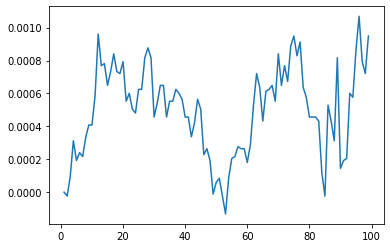

In [33]:
returns.cumsum().plot();

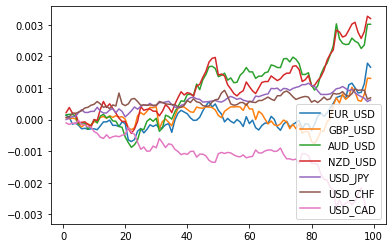

In [34]:
def get_mid_candles(inst, count=100, timeframe='M1'):
        params=dict(price='M', granularity=timeframe, count=count)
        candles = ctx.instrument.candles(inst, **params).get('candles')
        prices=['mid']
        s=[]
        for c in candles:
            c=c.dict()
            row={}
            row['volume'] = c['volume']
            for p in prices:
                for oh in 'c':
                    row[f'{p}_{oh}']=float(c[p][oh])
            s.append(row)
        df= pd.DataFrame.from_dict(s)
        return df
    
def get_major_returns():
    insts=['EUR_USD', 'GBP_USD', 'AUD_USD', 'NZD_USD', 'USD_JPY', 'USD_CHF', 'USD_CAD']
    df=pd.DataFrame()
    
    for i in insts:
        close = get_mid_candles(i).mid_c
        df[i] = np.log(close/close.shift(1)).cumsum()
    return df

df = get_major_returns()       
df.plot();

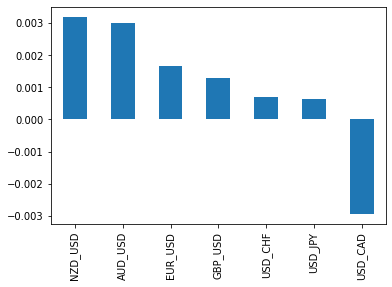

In [35]:
df.iloc[-1].sort_values(ascending=False).plot(kind='bar');

In [36]:
df

,EUR_USD,GBP_USD,AUD_USD,NZD_USD,USD_JPY,USD_CHF,USD_CAD
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000128,0.000061,0.000151,0.000220,0.000000,0.000065,-0.000109
2,0.000082,0.000023,0.000165,0.000382,0.000043,0.000086,-0.000155
3,-0.000147,0.000046,0.000165,0.000206,0.000095,0.000194,-0.000109
4,-0.000110,0.000023,0.000110,0.000191,0.000095,0.000194,-0.000132
...,...,...,...,...,...,...,...
95,0.000842,0.000610,0.002427,0.002757,0.000777,0.000926,-0.002347
96,0.000861,0.000579,0.002249,0.002566,0.000725,0.000937,-0.002153
97,0.001135,0.000800,0.002358,0.002786,0.000674,0.000926,-0.002589
98,0.001784,0.001310,0.003015,0.003269,0.000570,0.000646,-0.002986
